In [32]:
import numpy as np
import pandas as pd
import pickle, csv
import os

from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Input, concatenate, Flatten, Reshape,MaxPooling2D, Conv2D, TimeDistributed
from keras import regularizers
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models


from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow.keras.backend as K
K.clear_session()

In [33]:
# Load powerprice data and format it
df_powerprice = pd.read_csv("data/PowerPrice.csv")
df_powerprice["Time"] = pd.to_datetime(df_powerprice["Time"], infer_datetime_format=True)
df_powerprice = df_powerprice.drop(columns=["Time"])
df_powerprice

,DayAhead,Spot,REBAP
0,2.83200,3.688,-4.566
1,2.37575,4.245,-13.964
2,1.91950,3.161,0.345
3,1.46325,1.664,3.048
4,1.00700,3.110,-6.679
...,...,...,...
35035,3.77625,3.342,4.856
35036,3.73900,4.425,8.561
35037,3.70175,2.473,6.076
35038,3.66450,3.241,11.797


In [34]:
# Load spatial data and format it
datasets = []
for filename in os.listdir("data/Spatial"):
    if filename.endswith(".pickle"):
        with open(os.path.join("data/Spatial", filename), "rb") as file:
            data = pickle.load(file)
            if data.shape == (100, 35040):
                datasets.append(data)
            else:
                print(f"Skipping {filename}: unexpected shape {data.shape}")

In [35]:
# Convert the list of arrays to a 3D array
spatial_data = np.stack(datasets, axis=0)

spatial_data = spatial_data.reshape((spatial_data.shape[0], spatial_data.shape[1], spatial_data.shape[2]))

# transpose the second and third dimensions to get shape (13, 35040, 100)
spatial_data = spatial_data.transpose((0, 1, 2))

spatial_data.shape

(13, 100, 35040)

In [36]:
# Load mask and reshape to match desired output shape
mask = pd.read_csv("germany/mask.csv", header=None).values
#mask = mask_df.values.reshape((40, 40, 1))

mask.shape

(30, 30)

In [37]:
spatial_data.shape

(13, 100, 35040)

In [38]:
image_all = np.zeros((35040, 30, 30, 13))
for j in range(spatial_data.shape[2]):
    for i in range(spatial_data.shape[0]):
        image = np.zeros((30, 30))
        for s in range(spatial_data.shape[1]):
            image[mask == s] = spatial_data[i,s,j]
        #print(i)
        image_all[j, :, :, i] = image

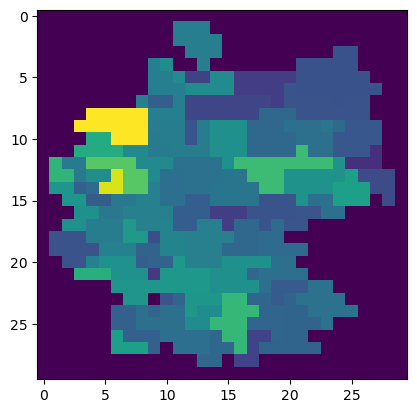

In [39]:
plt.imshow(image_all[35030,:,:,4])
plt.show()

In [40]:
image_all.shape

(35040, 30, 30, 13)

In [41]:
#input_2 = df_powerprice["DayAhead"].values.reshape((-1, 4))
#input_2.shape

In [42]:
output = df_powerprice["Spot"][:35036].values

scaler = MinMaxScaler()
output = scaler.fit_transform(output.reshape(-1, 1))

output.shape

(35036, 1)

In [43]:
def split_datasets(df, window_size, look_ahead):
    X = []
    for i in range(len(df)-window_size-look_ahead):
        row = df[i:i+window_size,:,:,:]
        X.append(row)
    return np.array(X)

In [44]:
window_size = 4
look_ahead = 0
input_1 = split_datasets(image_all, window_size=window_size, look_ahead=look_ahead)

print(f"X_train shape : {input_1.shape}")

X_train shape : (35036, 4, 30, 30, 13)


In [45]:
# Reshape the input array to a 2D array
input_1_2d = input_1.reshape(-1, input_1.shape[-1])

# Scale the array using MinMaxScaler
scaler = MinMaxScaler()
input_1_2d_scaled = scaler.fit_transform(input_1_2d)

# Reshape the scaled array back to a 4D array
X = input_1_2d_scaled.reshape(input_1.shape)

X.shape

(35036, 4, 30, 30, 13)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, output, test_size=0.3, random_state=15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=15)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12262, 4, 30, 30, 13)
y_train shape: (12262, 1)
X_val shape: (12263, 4, 30, 30, 13)
y_val shape: (12263, 1)
X_test shape: (10511, 4, 30, 30, 13)
y_test shape: (10511, 1)


In [47]:
# Add convolutional layers to reduce the image to a 10-dimensional vector

#model.add(Reshape((-1, 30, 30, 13))(X_train.shape))
time_steps =4
width = 30
height = 30
channel = 13

cnn1 = Conv2D(filters=16,kernel_size=(3,3), activation='relu', input_shape=(30,30, 13))
cnn2 = MaxPooling2D(pool_size=(2,2))

cnn3 = Conv2D(filters=32,kernel_size=(3,3),activation='relu')

cnn4 = MaxPooling2D(pool_size=(2,2))

time_series_shape = Input(shape=(time_steps, width, height, channel))

fcnn = Dense(10,activation='relu',name='output')

lstm = LSTM(1, name='lstm1_1')

In [48]:
#model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(30, 30, 13)))

model = Sequential()
model.add(TimeDistributed(cnn1))
model.add(TimeDistributed(cnn2))
model.add(TimeDistributed(cnn3))
model.add(TimeDistributed(cnn4))

model.add(Reshape((-1, 6*6*32)))

model.add(TimeDistributed(fcnn))

model.add(lstm)

#model.add(Flatten())

#model.add(Reshape((-1, -1, -1)))

## Add an LSTM layer to process the sequential data

#model.add(LSTM(units=64, input_shape=(4, 10), return_sequences=False))



# Add a dense layer to produce the final output

#model.add(Dense(units=1, activation='linear'))

In [49]:
# Compile the model with an appropriate optimizer and loss function

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [50]:
# Print a summary of the model architecture

model.build(X_train.shape)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (12262, 4, 28, 28, 16)   1888      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (12262, 4, 14, 14, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (12262, 4, 12, 12, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (12262, 4, 6, 6, 32)     0         
 tributed)                                                       
                                                                 
 reshape (Reshape)           (12262, 4, 1152)          0

In [51]:
# Define callbacks for early stopping and checkpoint saving
es = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

In [52]:
cp = ModelCheckpoint(filepath="training/cnn-lstm/", 
                      save_best_only=True,
                      monitor='val_loss', 
                      mode='min', 
                      save_weights_only=False, 
                      verbose=1)

In [53]:
# Fit the model on the training data
history = model.fit(X_train, y_train, batch_size=5, epochs=1000, validation_data=(X_val, y_val), callbacks=[cp, es])

Epoch 1/1000
2450/2453 [============================>.] - ETA: 0s - loss: 5.0000e-04 - root_mean_squared_error: 0.0224
Epoch 1: val_loss improved from inf to 0.00030, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 25s 9ms/step - loss: 5.0068e-04 - root_mean_squared_error: 0.0224 - val_loss: 3.0169e-04 - val_root_mean_squared_error: 0.0174
Epoch 2/1000
2447/2453 [============================>.] - ETA: 0s - loss: 2.9267e-04 - root_mean_squared_error: 0.0171
Epoch 2: val_loss improved from 0.00030 to 0.00026, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 20s 8ms/step - loss: 2.9245e-04 - root_mean_squared_error: 0.0171 - val_loss: 2.6235e-04 - val_root_mean_squared_error: 0.0162
Epoch 3/1000
2437/2453 [============================>.] - ETA: 0s - loss: 2.8125e-04 - root_mean_squared_error: 0.0168
Epoch 3: val_loss improved from 0.00026 to 0.00026, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 19s 8ms/step - loss: 2.8151e-04 - root_mean_squared_error: 0.0168 - val_loss: 2.5788e-04 - val_root_mean_squared_error: 0.0161
Epoch 4/1000
2443/2453 [============================>.] - ETA: 0s - loss: 2.6866e-04 - root_mean_squared_error: 0.0164
Epoch 4: val_loss did not improve from 0.00026
2453/2453 [==============================] - 13s 5ms/step - loss: 2.6813e-04 - root_mean_squared_error: 0.0164 - val_loss: 2.5973e-04 - val_root_mean_squared_error: 0.0161
Epoch 5/1000
2438/2453 [============================>.] - ETA: 0s - loss: 2.6326e-04 - root_mean_squared_error: 0.0162
Epoch 5: val_loss improved from 0.00026 to 0.00024, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 19s 8ms/step - loss: 2.6248e-04 - root_mean_squared_error: 0.0162 - val_loss: 2.3523e-04 - val_root_mean_squared_error: 0.0153
Epoch 6/1000
2440/2453 [============================>.] - ETA: 0s - loss: 2.4730e-04 - root_mean_squared_error: 0.0157
Epoch 6: val_loss did not improve from 0.00024
2453/2453 [==============================] - 12s 5ms/step - loss: 2.4738e-04 - root_mean_squared_error: 0.0157 - val_loss: 2.8199e-04 - val_root_mean_squared_error: 0.0168
Epoch 7/1000
2446/2453 [============================>.] - ETA: 0s - loss: 2.4352e-04 - root_mean_squared_error: 0.0156
Epoch 7: val_loss did not improve from 0.00024
2453/2453 [==============================] - 12s 5ms/step - loss: 2.4306e-04 - root_mean_squared_error: 0.0156 - val_loss: 2.7551e-04 - val_root_mean_squared_error: 0.0166
Epoch 8/1000
2442/2453 [============================>.] - ETA: 0s - loss: 2.3362e-04 - root_mean_squared_error: 0.0153
Epoch 8: val_loss improved from 0

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 19s 8ms/step - loss: 2.3332e-04 - root_mean_squared_error: 0.0153 - val_loss: 2.0942e-04 - val_root_mean_squared_error: 0.0145
Epoch 9/1000
2447/2453 [============================>.] - ETA: 0s - loss: 2.2256e-04 - root_mean_squared_error: 0.0149
Epoch 9: val_loss did not improve from 0.00021
2453/2453 [==============================] - 12s 5ms/step - loss: 2.2221e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.2688e-04 - val_root_mean_squared_error: 0.0151
Epoch 10/1000
2450/2453 [============================>.] - ETA: 0s - loss: 2.2062e-04 - root_mean_squared_error: 0.0149
Epoch 10: val_loss improved from 0.00021 to 0.00021, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 20s 8ms/step - loss: 2.2053e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.0644e-04 - val_root_mean_squared_error: 0.0144
Epoch 11/1000
2445/2453 [============================>.] - ETA: 0s - loss: 2.1224e-04 - root_mean_squared_error: 0.0146
Epoch 11: val_loss did not improve from 0.00021
2453/2453 [==============================] - 12s 5ms/step - loss: 2.1224e-04 - root_mean_squared_error: 0.0146 - val_loss: 2.2017e-04 - val_root_mean_squared_error: 0.0148
Epoch 12/1000
2444/2453 [============================>.] - ETA: 0s - loss: 2.0314e-04 - root_mean_squared_error: 0.0143
Epoch 12: val_loss did not improve from 0.00021
2453/2453 [==============================] - 13s 5ms/step - loss: 2.0282e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.1133e-04 - val_root_mean_squared_error: 0.0145
Epoch 13/1000
2443/2453 [============================>.] - ETA: 0s - loss: 1.9509e-04 - root_mean_squared_error: 0.0140
Epoch 13: val_loss did not i

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 19s 8ms/step - loss: 1.9319e-04 - root_mean_squared_error: 0.0139 - val_loss: 2.0133e-04 - val_root_mean_squared_error: 0.0142
Epoch 16/1000
2441/2453 [============================>.] - ETA: 0s - loss: 1.8382e-04 - root_mean_squared_error: 0.0136
Epoch 16: val_loss improved from 0.00020 to 0.00019, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 18s 7ms/step - loss: 1.8332e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.8721e-04 - val_root_mean_squared_error: 0.0137
Epoch 17/1000
2440/2453 [============================>.] - ETA: 0s - loss: 1.8927e-04 - root_mean_squared_error: 0.0138
Epoch 17: val_loss did not improve from 0.00019
2453/2453 [==============================] - 12s 5ms/step - loss: 1.8879e-04 - root_mean_squared_error: 0.0137 - val_loss: 1.9512e-04 - val_root_mean_squared_error: 0.0140
Epoch 18/1000
2437/2453 [============================>.] - ETA: 0s - loss: 1.6703e-04 - root_mean_squared_error: 0.0129
Epoch 18: val_loss did not improve from 0.00019
2453/2453 [==============================] - 12s 5ms/step - loss: 1.6660e-04 - root_mean_squared_error: 0.0129 - val_loss: 2.1741e-04 - val_root_mean_squared_error: 0.0147
Epoch 19/1000
2447/2453 [============================>.] - ETA: 0s - loss: 1.7562e-04 - root_mean_squared_error: 0.0133
Epoch 19: val_loss did not i

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 18s 7ms/step - loss: 1.7664e-04 - root_mean_squared_error: 0.0133 - val_loss: 1.8022e-04 - val_root_mean_squared_error: 0.0134
Epoch 23/1000
2452/2453 [============================>.] - ETA: 0s - loss: 1.6518e-04 - root_mean_squared_error: 0.0129
Epoch 23: val_loss did not improve from 0.00018
2453/2453 [==============================] - 13s 5ms/step - loss: 1.6516e-04 - root_mean_squared_error: 0.0129 - val_loss: 2.4270e-04 - val_root_mean_squared_error: 0.0156
Epoch 24/1000
2442/2453 [============================>.] - ETA: 0s - loss: 1.5467e-04 - root_mean_squared_error: 0.0124
Epoch 24: val_loss improved from 0.00018 to 0.00018, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 18s 7ms/step - loss: 1.5440e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.7893e-04 - val_root_mean_squared_error: 0.0134
Epoch 25/1000
2442/2453 [============================>.] - ETA: 0s - loss: 1.5475e-04 - root_mean_squared_error: 0.0124
Epoch 25: val_loss did not improve from 0.00018
2453/2453 [==============================] - 12s 5ms/step - loss: 1.5466e-04 - root_mean_squared_error: 0.0124 - val_loss: 2.1676e-04 - val_root_mean_squared_error: 0.0147
Epoch 26/1000
2443/2453 [============================>.] - ETA: 0s - loss: 1.5712e-04 - root_mean_squared_error: 0.0125
Epoch 26: val_loss did not improve from 0.00018
2453/2453 [==============================] - 11s 4ms/step - loss: 1.5729e-04 - root_mean_squared_error: 0.0125 - val_loss: 2.0227e-04 - val_root_mean_squared_error: 0.0142
Epoch 27/1000
2443/2453 [============================>.] - ETA: 0s - loss: 1.5134e-04 - root_mean_squared_error: 0.0123
Epoch 27: val_loss did not i

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 17s 7ms/step - loss: 1.3478e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.7355e-04 - val_root_mean_squared_error: 0.0132
Epoch 33/1000
2450/2453 [============================>.] - ETA: 0s - loss: 1.4065e-04 - root_mean_squared_error: 0.0119
Epoch 33: val_loss did not improve from 0.00017
2453/2453 [==============================] - 12s 5ms/step - loss: 1.4054e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.7728e-04 - val_root_mean_squared_error: 0.0133
Epoch 34/1000
2448/2453 [============================>.] - ETA: 0s - loss: 1.4078e-04 - root_mean_squared_error: 0.0119
Epoch 34: val_loss improved from 0.00017 to 0.00017, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 18s 7ms/step - loss: 1.4064e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.6626e-04 - val_root_mean_squared_error: 0.0129
Epoch 35/1000
2450/2453 [============================>.] - ETA: 0s - loss: 1.3114e-04 - root_mean_squared_error: 0.0115
Epoch 35: val_loss did not improve from 0.00017
2453/2453 [==============================] - 11s 4ms/step - loss: 1.3130e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.7699e-04 - val_root_mean_squared_error: 0.0133
Epoch 36/1000
2439/2453 [============================>.] - ETA: 0s - loss: 1.2742e-04 - root_mean_squared_error: 0.0113
Epoch 36: val_loss did not improve from 0.00017
2453/2453 [==============================] - 11s 5ms/step - loss: 1.2712e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.7268e-04 - val_root_mean_squared_error: 0.0131
Epoch 37/1000
2438/2453 [============================>.] - ETA: 0s - loss: 1.3292e-04 - root_mean_squared_error: 0.0115
Epoch 37: val_loss did not i

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 18s 7ms/step - loss: 1.2039e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.6209e-04 - val_root_mean_squared_error: 0.0127
Epoch 46/1000
2446/2453 [============================>.] - ETA: 0s - loss: 1.1898e-04 - root_mean_squared_error: 0.0109
Epoch 46: val_loss did not improve from 0.00016
2453/2453 [==============================] - 13s 5ms/step - loss: 1.1909e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.8876e-04 - val_root_mean_squared_error: 0.0137
Epoch 47/1000
2449/2453 [============================>.] - ETA: 0s - loss: 1.2347e-04 - root_mean_squared_error: 0.0111
Epoch 47: val_loss did not improve from 0.00016
2453/2453 [==============================] - 13s 5ms/step - loss: 1.2341e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.9711e-04 - val_root_mean_squared_error: 0.0140
Epoch 48/1000
2445/2453 [============================>.] - ETA: 0s - loss: 2.9913e-04 - root_mean_squared_error: 0.0173
Epoch 48: val_loss did not i

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 18s 7ms/step - loss: 1.1305e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.5848e-04 - val_root_mean_squared_error: 0.0126
Epoch 63/1000
2438/2453 [============================>.] - ETA: 0s - loss: 1.0281e-04 - root_mean_squared_error: 0.0101
Epoch 63: val_loss did not improve from 0.00016
2453/2453 [==============================] - 11s 5ms/step - loss: 1.0271e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.8303e-04 - val_root_mean_squared_error: 0.0135
Epoch 64/1000
2437/2453 [============================>.] - ETA: 0s - loss: 1.0485e-04 - root_mean_squared_error: 0.0102
Epoch 64: val_loss did not improve from 0.00016
2453/2453 [==============================] - 11s 5ms/step - loss: 1.0484e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.8996e-04 - val_root_mean_squared_error: 0.0138
Epoch 65/1000
2453/2453 [==============================] - ETA: 0s - loss: 1.0162e-04 - root_mean_squared_error: 0.0101
Epoch 65: val_loss did not i

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


2453/2453 [==============================] - 19s 8ms/step - loss: 1.0870e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.5411e-04 - val_root_mean_squared_error: 0.0124
Epoch 75/1000
2440/2453 [============================>.] - ETA: 0s - loss: 8.9817e-05 - root_mean_squared_error: 0.0095
Epoch 75: val_loss did not improve from 0.00015
2453/2453 [==============================] - 12s 5ms/step - loss: 8.9887e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.8329e-04 - val_root_mean_squared_error: 0.0135
Epoch 76/1000
2450/2453 [============================>.] - ETA: 0s - loss: 9.2574e-05 - root_mean_squared_error: 0.0096
Epoch 76: val_loss did not improve from 0.00015
2453/2453 [==============================] - 12s 5ms/step - loss: 9.2584e-05 - root_mean_squared_error: 0.0096 - val_loss: 2.1005e-04 - val_root_mean_squared_error: 0.0145
Epoch 77/1000
2437/2453 [============================>.] - ETA: 0s - loss: 9.1967e-05 - root_mean_squared_error: 0.0096
Epoch 77: val_loss did not i

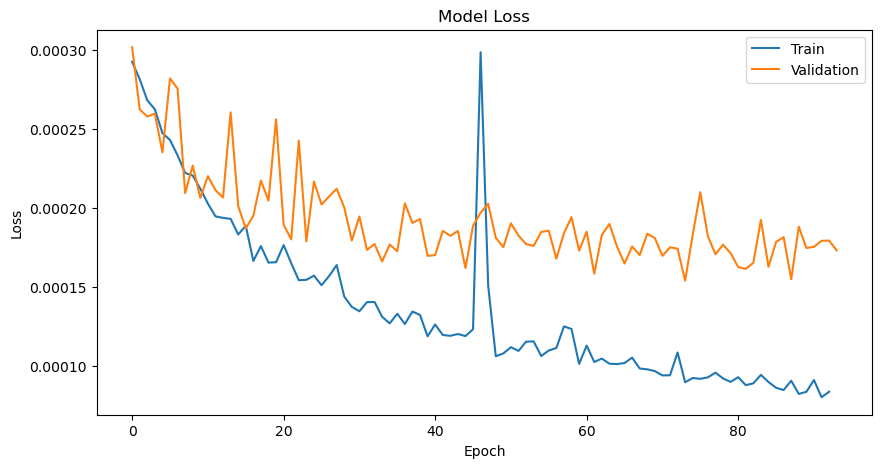

In [54]:
#Plot the training and validation loss

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### getting the result of (32, 6, 40, 40, 13)

In [237]:
image = image_slided[np.random.choice(image_slided.shape[0], 32, replace=False)] # just randomly picking the sample from 35035.

image = image.reshape(32, -1, 40, 40, 13)

print(f"image shape: {image.shape}")

image shape: (32, 6, 40, 40, 13)


#### getting the result of (32*6, 40, 40, 13)

In [240]:
image = image.reshape(-1, 40, 40, 13)

image.shape

(192, 40, 40, 13)

In [241]:
df_input = Input(shape=(40, 40, 13))
conv_layer = Conv2D(32, kernel_size=(3,3), activation="relu")(df_input)
conv_layer = MaxPooling2D(pool_size=(2, 2))(conv_layer)
conv_layer = Conv2D(64, kernel_size=(3, 3), activation="relu")(conv_layer)
conv_layer = MaxPooling2D(pool_size=(2, 2))(conv_layer)
flatten_layer = Flatten()(conv_layer)
fcnn_layer = Dense(64, activation="relu")(flatten_layer)
fcnn_layer = Dropout(0.2)(fcnn_layer)
fcnn_layer = Dense(32, activation="relu")(fcnn_layer)
fcnn_layer = Dropout(0.2)(fcnn_layer)
fcnn_output = Dense(10, activation="relu")(fcnn_layer)

fcnn_output.shape

TensorShape([None, 10])

In [242]:
model = Model(inputs=df_input, outputs=fcnn_output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 40, 40, 13)]      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 38, 38, 32)        3776      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 19, 19, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0   

In [244]:
# Compile the model with optimizer and loss function
model.compile(optimizer='adam', loss='mse')


In [ ]:
CNN

In [ ]:
(32*6, 4, 4, 32)

In [ ]:
Reshape

In [ ]:
(32*6, 4*4*32)

In [ ]:
FNN

In [ ]:
(32*6, 1)

In [ ]:
Reshape

In [ ]:
(32, 6, 1)